In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa #common default audio library

In [2]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [3]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [4]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i], cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [5]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [6]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

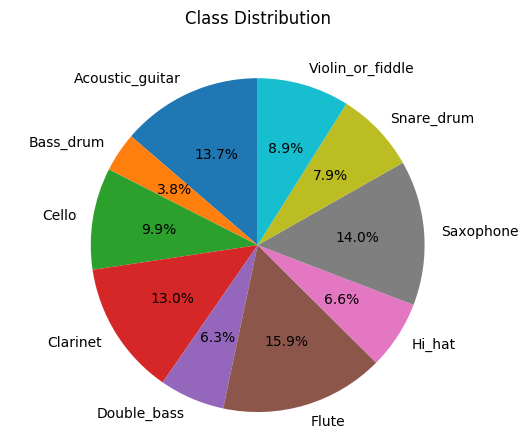

In [7]:
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('wavfiles_combined/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate
    
classes = list(np.unique(df.label))

class_dist = df.groupby(['label'])['length'].mean()

# plotting the class ditribution
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

In [8]:
signals = {}
fft = {}
fbank = {}
mfccs = {}
    
for c in classes:
    wav_file = df[df.label==c].iloc[0,0]
    signal, rate = librosa.load('wavfiles_combined/'+wav_file, sr=44100)
    mask = envelope(signal, rate, threshold=0.0005)
    signal = signal[mask]
    signals[c] = signal
    
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c] = bank
    
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

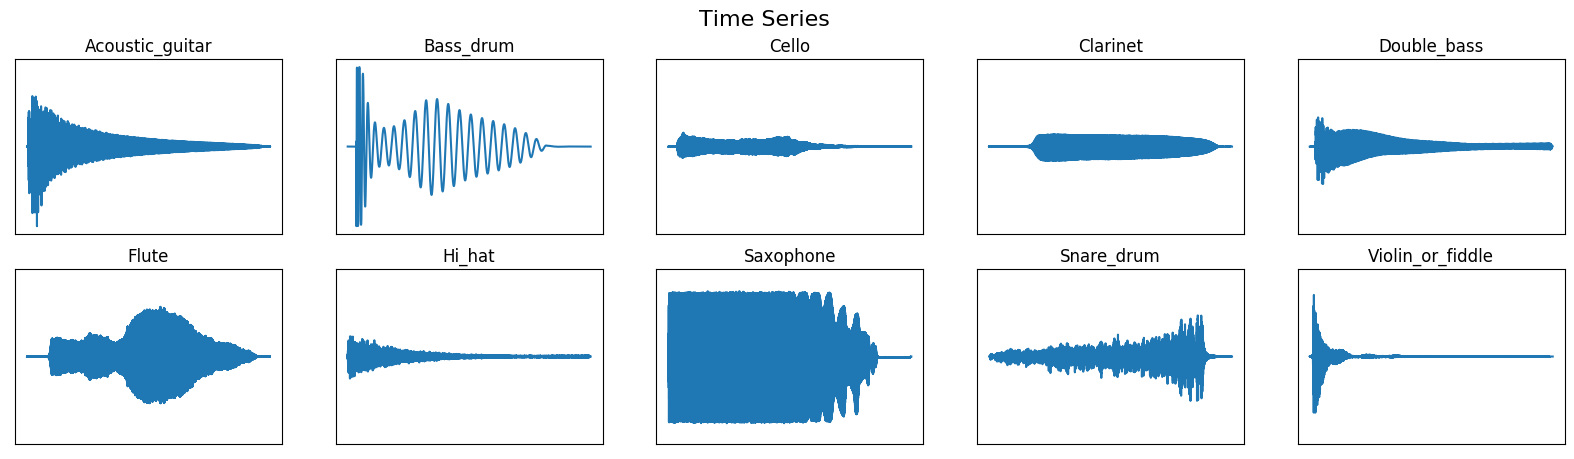

In [9]:
plot_signals(signals)
plt.show()

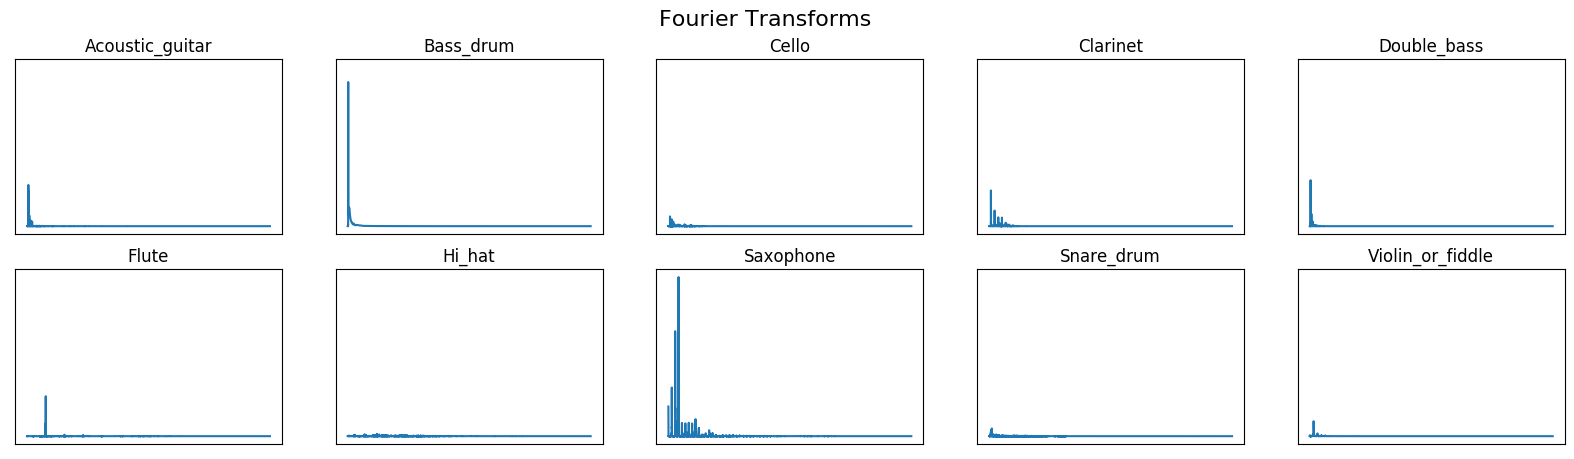

In [10]:
plot_fft(fft)
plt.show()

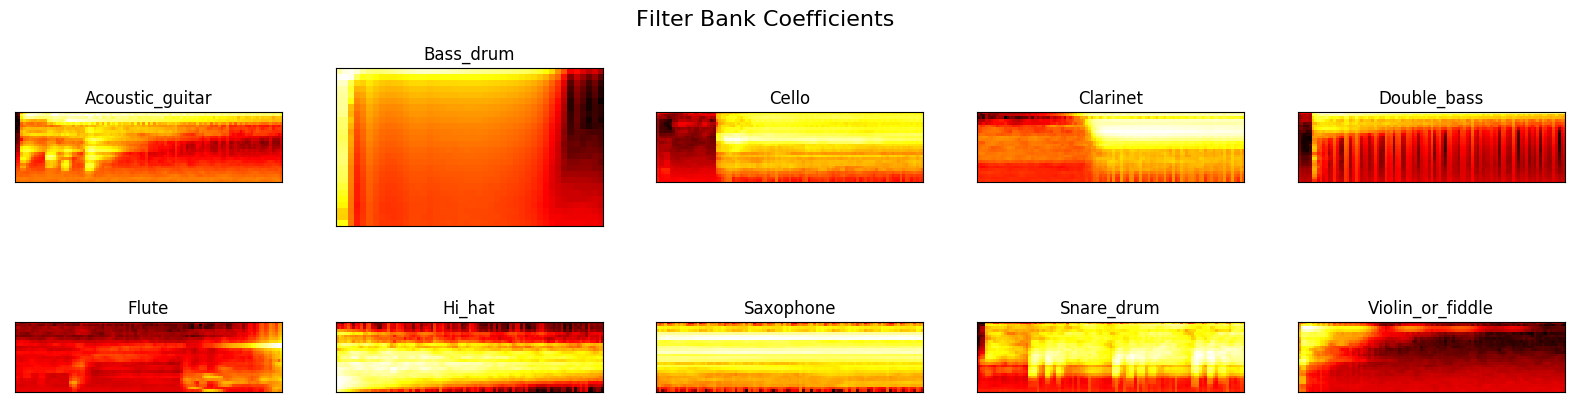

In [11]:
plot_fbank(fbank)
plt.show()

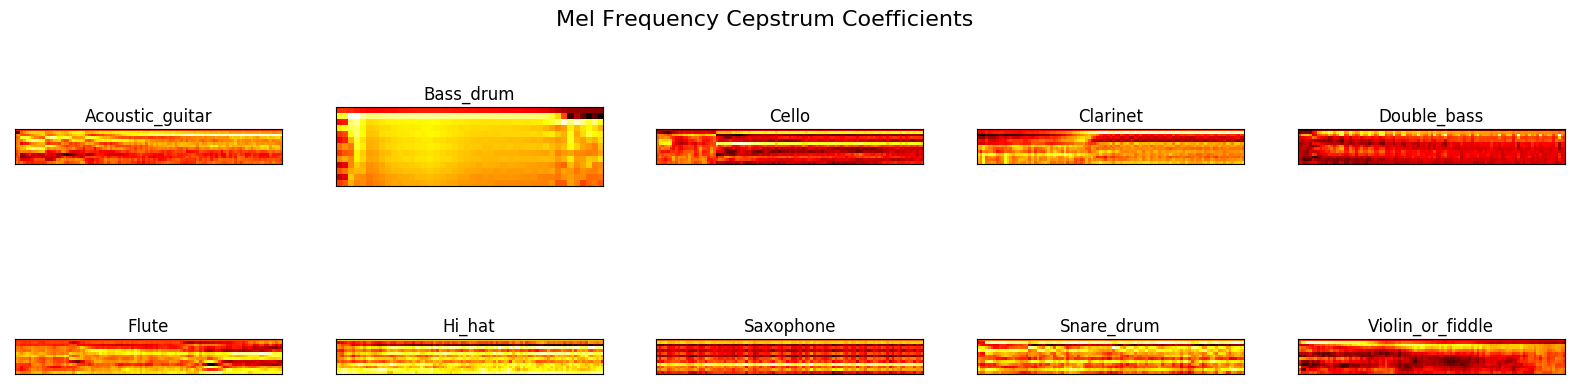

In [12]:
plot_mfccs(mfccs)
plt.show()

In [13]:
if len(os.listdir('clean')) == 0:
    for f in tqdm(df.fname):
        signal, rate = librosa.load('wavfiles_combined/'+f, sr=16000)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename='clean/'+f, rate=rate, data=signal[mask])